In [6]:
import numpy as np
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

import seaborn as sns
from data_preprocessing import load_combined_data
import torch.nn.functional as F

In [7]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # disables optimizations for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [8]:
# Function to load preprocessed data
#combined_data, combined_labels = load_combined_data(data_path='ES_InterDown_combined_data.csv', labels_path='ES_InterDown_combined_labels.csv',downsample = True)

# Load the combined_labels.npy file
output_dir = "./processed_data/"

# Load the saved NumPy arrays
combined_data = np.load(os.path.join(output_dir, "combined_data.npy"))
combined_labels = np.load(os.path.join(output_dir, "combined_labels.npy"))


In [9]:

# Label mapping
label_info = {
    2: 'tightening',
    3: 'untightening',
    4: 'motor_activity_cw',
    5: 'motor_activity_ccw',
    6: 'manual_motor_rotation',
    7: 'shaking',
    14: 'tightening_double'
}

valid_labels = list(label_info.keys())
valid_indices = np.isin(combined_labels, valid_labels)
X = combined_data[valid_indices]
y = combined_labels[valid_indices]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) # can be removed as our code uses binary labels directly

# Convert to tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y_encoded)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, stratify=y)

# Print label distribution
unique_train, counts_train = torch.unique(y_train, return_counts=True)
unique_test, counts_test = torch.unique(y_test, return_counts=True)

scalers = {}
for i in range(X_train.shape[2]):
    scalers[i] = StandardScaler()
    X_train[:, :, i] = torch.FloatTensor(scalers[i].fit_transform(X_train[:, :, i]))
    X_test[:, :, i] = torch.FloatTensor(scalers[i].transform(X_test[:, :, i]))


# --- Weighted Sampling for class imbalance ---
class_sample_counts = np.array([(y_train == t).sum() for t in torch.unique(y_train)])
weights = 1. / class_sample_counts
samples_weight = np.array([weights[t] for t in y_train.numpy()])
samples_weight = torch.from_numpy(samples_weight).float()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
#train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

print("Train set size:", len(train_loader.dataset))
print("Test set size:", len(test_loader.dataset))
print(f"Total dataset size: {len(X_train) + len(X_test)}")
print("Label distribution in training set:", counts_train)
print("Label distribution in test set:", counts_test)

Train set size: 1400
Test set size: 350
Total dataset size: 1750
Label distribution in training set: tensor([657, 267, 238, 105,  53,  70,  10])
Label distribution in test set: tensor([164,  67,  60,  26,  14,  17,   2])


EnhancedToolLSTM(
  (lstm): LSTM(22, 16, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=16, out_features=7, bias=True)
)
Epoch 1: Train Acc = 0.2193, Test Acc = 0.5571
Epoch 2: Train Acc = 0.5564, Test Acc = 0.6286
Epoch 3: Train Acc = 0.6386, Test Acc = 0.7257
Epoch 4: Train Acc = 0.7321, Test Acc = 0.7857
Epoch 5: Train Acc = 0.7821, Test Acc = 0.8086
Epoch 6: Train Acc = 0.8350, Test Acc = 0.8429
Epoch 7: Train Acc = 0.8614, Test Acc = 0.8514
Epoch 8: Train Acc = 0.8821, Test Acc = 0.8743
Epoch 9: Train Acc = 0.9036, Test Acc = 0.8829
Epoch 10: Train Acc = 0.9100, Test Acc = 0.8943
Epoch 11: Train Acc = 0.9200, Test Acc = 0.8971
Epoch 12: Train Acc = 0.9157, Test Acc = 0.8914
Epoch 13: Train Acc = 0.9229, Test Acc = 0.9029
Epoch 14: Train Acc = 0.9221, Test Acc = 0.9086
Epoch 15: Train Acc = 0.9293, Test Acc = 0.9086
Epoch 16: Train Acc = 0.9229, Test Acc = 0.8971
Epoch 17: Train Acc = 0.9307, Test Acc = 0.9143
Epoch 18: Train Acc = 0.9357, 

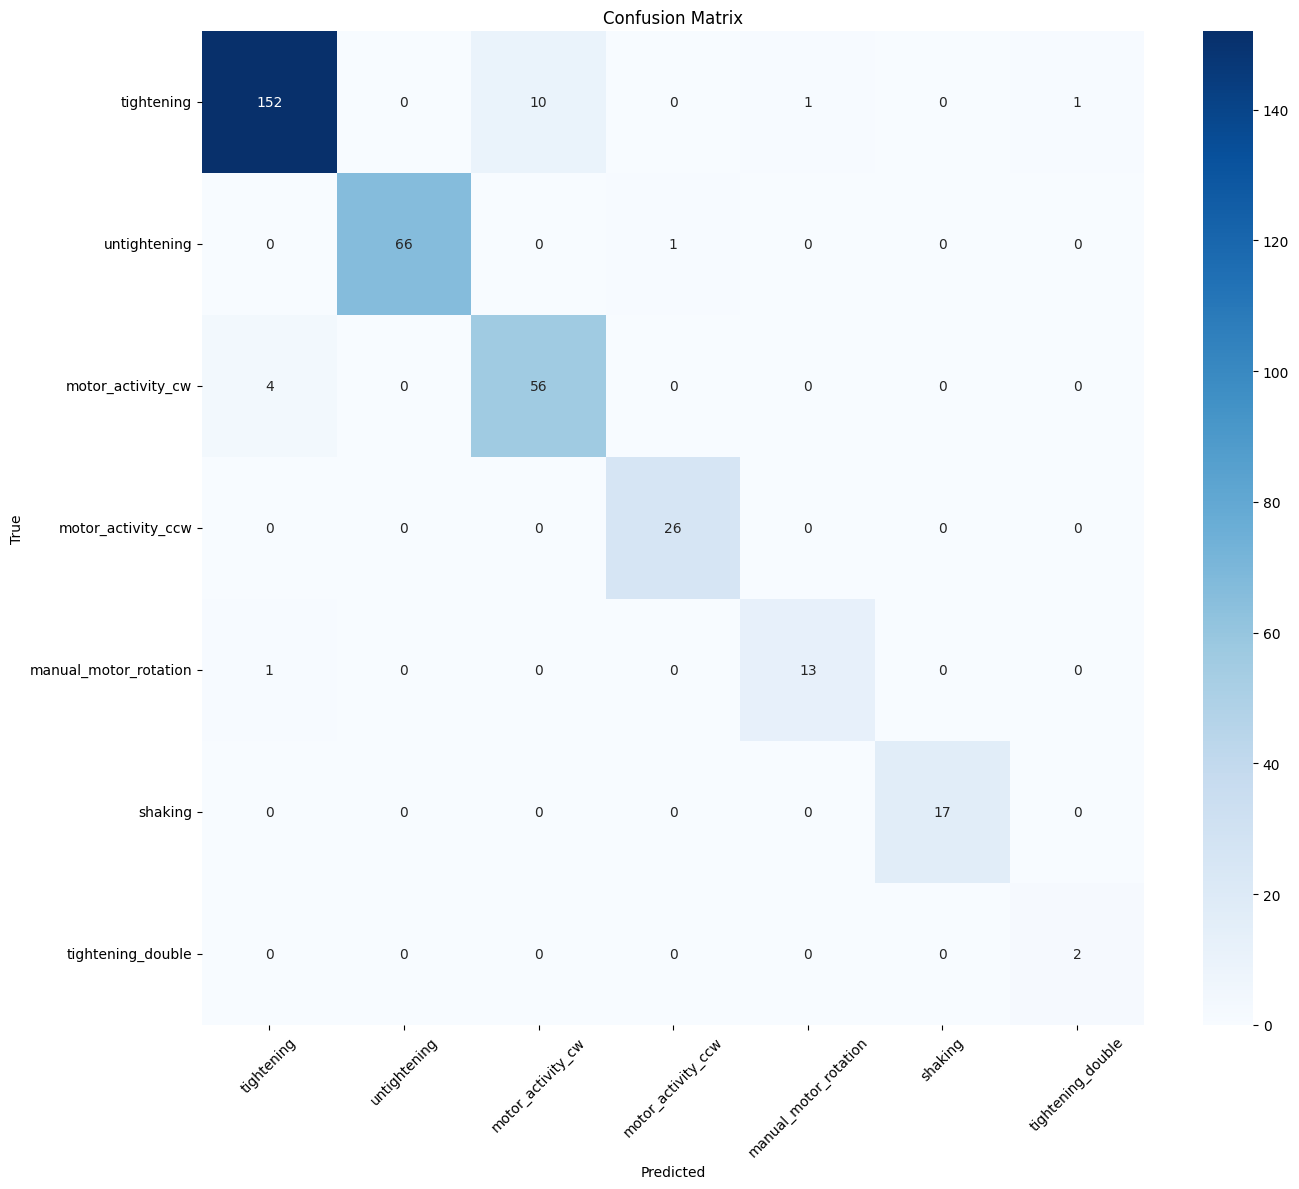


Classification Report:
                       precision    recall  f1-score   support

           tightening       0.97      0.93      0.95       164
         untightening       1.00      0.99      0.99        67
    motor_activity_cw       0.85      0.93      0.89        60
   motor_activity_ccw       0.96      1.00      0.98        26
manual_motor_rotation       0.93      0.93      0.93        14
              shaking       1.00      1.00      1.00        17
    tightening_double       0.67      1.00      0.80         2

             accuracy                           0.95       350
            macro avg       0.91      0.97      0.93       350
         weighted avg       0.95      0.95      0.95       350



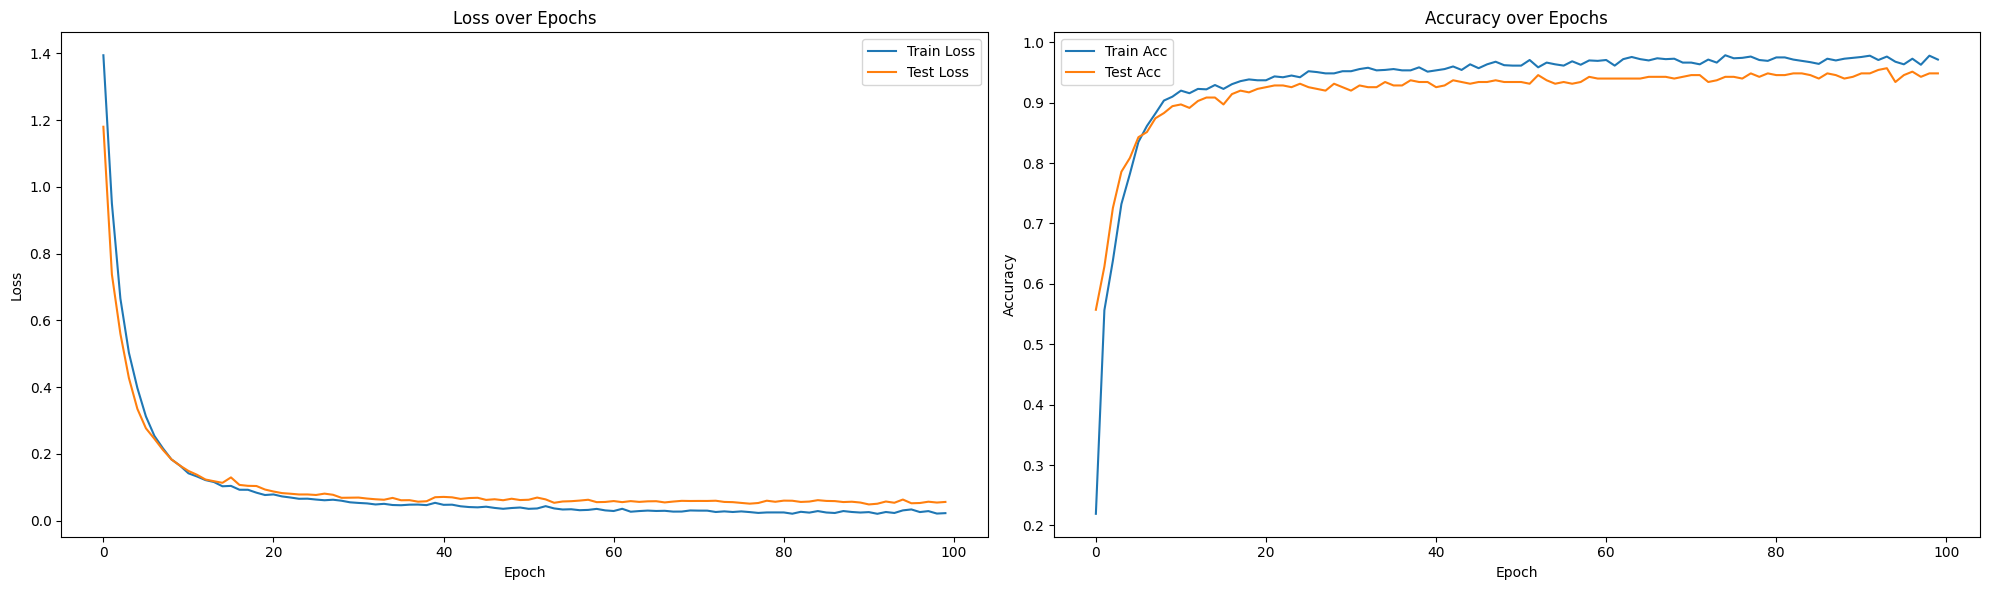

In [10]:

# Enhanced LSTM model with more hidden layers
class EnhancedToolLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.0):
        super(EnhancedToolLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                            batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        last_out = self.dropout1(last_out)
        out = self.fc(last_out)
        return out

class SimpleFocalLoss(nn.Module):
    """Simple Focal Loss without class weight adjustment."""
    def __init__(self, gamma=2.0, alpha=None):
        """
        Args:
            gamma (float): focusing parameter.
            alpha (Tensor, list, or None): class weights of shape (num_classes,)
        """
        super(SimpleFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = None
        if alpha is not None:
            if isinstance(alpha, (list, tuple)):
                self.alpha = torch.tensor(alpha, dtype=torch.float32)
            elif isinstance(alpha, torch.Tensor):
                self.alpha = alpha.float()

    def forward(self, inputs, targets):
        """
        Args:
            inputs (Tensor): shape (batch_size, num_classes), raw logits.
            targets (Tensor): shape (batch_size,), class indices.
        """
        device = inputs.device
        log_probs = F.log_softmax(inputs, dim=1)
        probs = log_probs.exp()

        # Select the log prob and prob of the true class
        log_probs_true = log_probs.gather(1, targets.view(-1, 1)).squeeze(1)
        probs_true = probs.gather(1, targets.view(-1, 1)).squeeze(1).clamp(min=1e-9, max=1.0)

        # If alpha is provided, apply per-sample weight
        if self.alpha is not None:
            alpha_t = self.alpha.to(device)[targets]  # (batch,)
            loss = -alpha_t * ((1 - probs_true) ** self.gamma) * log_probs_true
        else:
            loss = -((1 - probs_true) ** self.gamma) * log_probs_true

        return loss.mean()
    # def __init__(self, gamma=2.0):
    #     super(SimpleFocalLoss, self).__init__()
    #     self.gamma = gamma

    # def forward(self, inputs, targets):
    #     """
    #     Args:
    #         inputs (Tensor): logits, shape (batch, num_classes).
    #         targets (Tensor): class indices, shape (batch,).
    #     """
    #     log_probs = F.log_softmax(inputs, dim=1)
    #     log_probs_true = log_probs.gather(1, targets.view(-1, 1)).squeeze(1)
    #     probs_true = log_probs_true.exp().clamp(min=1e-9, max=1.0)

    #     loss = -((1 - probs_true) ** self.gamma) * log_probs_true
    #     return loss.mean()

#----------------------------------------------- Main Execution ----------------------------------------------------------------#
# Setup
num_of_classes = len(label_info)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedToolLSTM(input_dim=X.shape[2], 
                        hidden_dim=16,
                        output_dim=num_of_classes).to(device)
print(model)

# Initialize class weights (inverse of class frequencies)
initial_weights = 1. / counts_train.float()
initial_weights = initial_weights / initial_weights.sum()
initial_weights = initial_weights.to(device)

# Dynamic loss function
criterion = SimpleFocalLoss(gamma=2.0,alpha=None)  # Using SimpleFocalLoss with class weights
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct / total)
    # scheduler.step(test_losses[-1])

    print(f"Epoch {epoch+1}: Train Acc = {train_accuracies[-1]:.4f}, Test Acc = {test_accuracies[-1]:.4f}")

# --- Final Evaluation ---
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

# Metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"\nFinal Accuracy: {accuracy:.4f}")
print(f"Final Weighted F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = [label_info[i] for i in valid_labels]
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Training Curves
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(test_accuracies, label='Test Acc')
plt.legend()
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()
